In [1]:
import ai4rgym
from ai4rgym.envs.road import Road
import gymnasium as gym
import random
from utils import ensure_dir, ensure_dirs, eval_model

import numpy as np
from scipy import linalg
from scipy import sparse
import osqp
import matplotlib.pyplot as plt

In [7]:
################################### ENVIRONMENT SETUP - START ###################################

# SPECIFY THE VEHCILE PARAMETERS
bicycle_model_parameters = {
    "Lf" : 0.55*2.875,
    "Lr" : 0.45*2.875,
    "m"  : 2000.0,
    "Iz" : (1.0/12.0) * 2000.0 * (4.692**2+1.850**2),
    "Cm" : (1.0/100.0) * (1.0 * 400.0 * 9.0) / 0.2286,
    "Cd" : 0.5 * 0.24 * 2.2204 * 1.202,
    "delta_offset" : 0 * np.pi/180,
    "delta_request_max" : 45 * np.pi/180,
    "Ddelta_lower_limit" : -45 * np.pi/180,
    "Ddelta_upper_limit" :  45 * np.pi/180,
    "v_transition_min": 3.0,    # v_transition_min = 3.0 m/s # kinematic model
    "v_transition_max": 5.0,    # v_transition_max = 5.0 m/s # dynamic model
    "body_len_f" : (0.55*2.875) * 1.5,
    "body_len_r" : (0.45*2.875) * 1.5,
    "body_width" : 2.50,
}

# SPECIFY THE ROAD
road_elements_list = [
    {"type":"straight", "length":100.0},
    {"type":"curved", "curvature":1/800.0, "angle_in_degrees":15.0},
    {"type":"straight", "length":100.0},
    {"type":"curved", "curvature":-1/800.0, "angle_in_degrees":15.0},
    {"type":"straight", "length":100.0},
    {"type":"curved", "curvature":-1/800.0, "angle_in_degrees":15.0},
    {"type":"straight", "length":100.0},
    {"type":"curved", "curvature":1/800.0, "angle_in_degrees":15.0},
    {"type":"straight", "length":100.0},
]

# SPECIFY THE NUMERICAL INTEGRATION DETAILS
numerical_integration_parameters = {
    "method" : "rk4",
    "Ts" : 0.05,                # may want to reduce this even more 
    "num_steps_per_Ts" : 1,
}

py_init_min = 0.0
py_init_max =  0.0

v_init_min_in_kmh = 30.0
v_init_max_in_kmh = 30.0

initial_state_bounds = {
    "px_init_min" : 0.0,
    "px_init_max" : 0.0,
    "py_init_min" : py_init_min,
    "py_init_max" : py_init_max,
    "theta_init_min" : 0.0,
    "theta_init_max" : 0.0,
    "vx_init_min" : v_init_min_in_kmh * (1.0/3.6),
    "vx_init_max" : v_init_max_in_kmh * (1.0/3.6),
    "vy_init_min" : 0.0,
    "vy_init_max" : 0.0,
    "omega_init_min" : 0.0,
    "omega_init_max" : 0.0,
    "delta_init_min" : 0.0,
    "delta_init_max" : 0.0,
}

# SPECIFY THE TERMINATION PARAMETERS
termination_parameters = {
    "speed_lower_bound"  :  0.0,
    "speed_upper_bound"  :  (200.0/3.6),
    "distance_to_closest_point_upper_bound"  :  20.0,
    "reward_speed_lower_bound"  :  0.0,
    "reward_speed_upper_bound"  :  0.0,
    "reward_distance_to_closest_point_upper_bound"  :  0.0,
}

# SPECIFY THE OBSERVATION PARAMETERS
observation_parameters = {
    "should_include_ground_truth_px"                       :  "info",
    "should_include_ground_truth_py"                       :  "info",
    "should_include_ground_truth_theta"                    :  "info",
    "should_include_ground_truth_vx"                       :  "info",
    "should_include_ground_truth_vy"                       :  "info",
    "should_include_ground_truth_omega"                    :  "info",
    "should_include_ground_truth_delta"                    :  "info",
    "should_include_road_progress_at_closest_point"        :  "obs",
    "should_include_vx_sensor"                             :  "obs",
    "should_include_distance_to_closest_point"             :  "obs",
    "should_include_heading_angle_relative_to_line"        :  "obs",
    "should_include_heading_angular_rate_gyro"             :  "info",
    "should_include_closest_point_coords_in_body_frame"    :  "info",
    "should_include_look_ahead_line_coords_in_body_frame"  :  "info",
    "should_include_road_curvature_at_closest_point"       :  "info",
    "should_include_look_ahead_road_curvatures"            :  "info",

    "scaling_for_ground_truth_px"                       :  1.0,
    "scaling_for_ground_truth_py"                       :  1.0,
    "scaling_for_ground_truth_theta"                    :  1.0,
    "scaling_for_ground_truth_vx"                       :  1.0,
    "scaling_for_ground_truth_vy"                       :  1.0,
    "scaling_for_ground_truth_omega"                    :  1.0,
    "scaling_for_ground_truth_delta"                    :  1.0,
    "scaling_for_road_progress_at_closest_point"        :  1.0,
    "scaling_for_vx_sensor"                             :  1.0,
    "scaling_for_distance_to_closest_point"             :  1.0,
    "scaling_for_heading_angle_relative_to_line"        :  1.0,
    "scaling_for_heading_angular_rate_gyro"             :  1.0,
    "scaling_for_closest_point_coords_in_body_frame"    :  1.0,
    "scaling_for_look_ahead_line_coords_in_body_frame"  :  1.0,
    "scaling_for_road_curvature_at_closest_point"       :  1.0,
    "scaling_for_look_ahead_road_curvatures"            :  1.0,

    "vx_sensor_bias"    : 0.0,
    "vx_sensor_stddev"  : 0.1,

    "distance_to_closest_point_bias"    :  0.0,
    "distance_to_closest_point_stddev"  :  0.01,

    "heading_angle_relative_to_line_bias"    :  0.0,
    "heading_angle_relative_to_line_stddev"  :  0.01,

    "heading_angular_rate_gyro_bias"    :  0.0,
    "heading_angular_rate_gyro_stddev"  :  0.01,

    "closest_point_coords_in_body_frame_bias"    :  0.0,
    "closest_point_coords_in_body_frame_stddev"  :  0.0,

    "look_ahead_line_coords_in_body_frame_bias"    :  0.0,
    "look_ahead_line_coords_in_body_frame_stddev"  :  0.0,

    "road_curvature_at_closest_point_bias"    :  0.0,
    "road_curvature_at_closest_point_stddev"  :  0.0,

    "look_ahead_road_curvatures_bias"    :  0.0,
    "look_ahead_road_curvatures_stddev"  :  0.0,

    "look_ahead_line_coords_in_body_frame_distance"    :  100.0,
    "look_ahead_line_coords_in_body_frame_num_points"  :  10,
}


def create_env(road_elements_list):
    env = gym.make(
        "ai4rgym/autonomous_driving_env",
        render_mode=None,
        bicycle_model_parameters=bicycle_model_parameters,
        road_elements_list=road_elements_list,
        numerical_integration_parameters=numerical_integration_parameters,
        termination_parameters=termination_parameters,
        initial_state_bounds=initial_state_bounds,
        observation_parameters=observation_parameters,
    )

    # Set the integration method and time step
    Ts_sim = 0.05
    integration_method = "rk4"
    env.unwrapped.set_integration_method(integration_method)
    env.unwrapped.set_integration_Ts(Ts_sim)

    # Set the road condition
    env.unwrapped.set_road_condition(road_condition="wet")

    return env

################################### ENVIRONMENT SETUP - END ###################################




class RTI():
    def __init__(self, the_env, Ts, horizon, Q_weight, R_weight, Q_weight_ref, R_weight_ref, steering_kp, steering_kd):
        
        self.env = the_env
        self.Ts = Ts
        self.N = horizon

        self.Q = Q_weight
        self.R = R_weight

        self.Q_ref = Q_weight_ref
        self.R_ref = R_weight_ref

        self.kp = steering_kp
        self.kd = steering_kd

        self.prev_d = 0
    

    def k(self, progress):
        """
        Inputs:
            progress  : progress along the road (m)

        Return:
            road curvature at progress p_bar (1/m)
        """
        return self.env.unwrapped.road.convert_progression_to_curvature([progress])[0]




    def A_c(self, p_bar, d_bar, mu_bar, v_bar, F_bar, delta_bar):
        """
        Constructs the continuous-time linearization matrix A_c.

        Inputs:
            p_bar      : progress along the road (m)
            d_bar      : orthogonal distance to road (m)
            mu_bar     : heading relative to the path (rad)
            v_bar      : velocity (m/s)
            F_bar      : drive command (%)
            delta_bar  : steering angle (rad)

        Return:
            Ac        : 4x4 numpy matrix
        """

        kappa = self.k(p_bar)                    # road curvature at p_bar
        Cd = bicycle_model_parameters["Cd"] # drag coefficient
        m = bicycle_model_parameters["m"]   # mass of the vehicle (kg)
        lr = bicycle_model_parameters["Lr"] # distance from rear axle to center of gravity (m)
        
        # common terms
        denom = (1 + d_bar * kappa)
        cos_mu = np.cos(mu_bar)
        sin_mu = np.sin(mu_bar)
        tan_delta = np.tan(delta_bar)
        sign_v = np.sign(v_bar)

        # A_c entries
        r0_c1 = -kappa * v_bar * cos_mu / (denom**2)
        r0_c2 = -v_bar * sin_mu / denom
        r0_c3 = cos_mu / denom

        r1_c2 = v_bar * cos_mu
        r1_c3 = sin_mu

        r2_c1 = (kappa**2) * v_bar * cos_mu / (denom**2)
        r2_c2 = kappa * v_bar * sin_mu / (denom)
        r2_c3 = (tan_delta / lr) - (kappa * cos_mu / denom)

        r3_c3 = 2 * Cd * v_bar * sign_v / m
        
        
        Ac = np.array([
            [0, r0_c1, r0_c2, r0_c3],
            [0,     0, r1_c2, r1_c3],
            [0, r2_c1, r2_c2, r2_c3],
            [0,     0,     0, r3_c3]
        ])
        
        return Ac
    
    def B_c(self, v_bar, delta_bar):
        """
        Constructs the continuous-time linearization matrix B_c.

        Inputs:
            v_bar      : velocity (m/s)
            delta_bar  : steering angle (rad)

        Return:
            Bc        : 4x2 numpy matrix
        """

        Cm = bicycle_model_parameters["Cm"] # coefficient of something
        m = bicycle_model_parameters["m"]   # mass of the vehicle (kg)
        lr = bicycle_model_parameters["Lr"] # distance from rear axle to center of gravity (m)
        
        cos_delta = np.cos(delta_bar)

        if cos_delta == 0: # catch division by zero
            return None
        
        sec_delta = 1/cos_delta

        # B_c entries
        r2_c1 = v_bar * (sec_delta**2) / lr

        r3_c0 = Cm/m
        
        Bc = np.array([
            [0,         0],
            [0,         0],
            [0,     r2_c1],
            [r3_c0,     0]
        ])
        
        return Bc
    
    def g_c(self, p_bar, d_bar, mu_bar, v_bar, F_bar, delta_bar):
        """
        Constructs the continuous-time linearization matrix g_c.

        Inputs:
            p_bar      : progress along the road (m)
            d_bar      : orthogonal distance to road (m)
            mu_bar     : heading relative to the path (rad)
            v_bar      : velocity (m/s)
            F_bar      : drive command (%)
            delta_bar  : steering angle (rad)

        Return:
            gc        : 4x1 numpy matrix
        """

        kappa = self.k(p_bar)                    # road curvature at p_bar
        Cd = bicycle_model_parameters["Cd"] # drag coefficient
        Cm = bicycle_model_parameters["Cm"] #  coefficient
        m = bicycle_model_parameters["m"]   # mass of the vehicle (kg)
        lr = bicycle_model_parameters["Lr"] # distance from rear axle to center of gravity (m)
        
        # common terms
        denom = (1 + d_bar * kappa)
        cos_mu = np.cos(mu_bar)
        sin_mu = np.sin(mu_bar)
        tan_delta = np.tan(delta_bar)
        sign_v = np.sign(v_bar)

        # g_c entries
        r0_c0 = v_bar * cos_mu / denom
        r0_c1 = v_bar * sin_mu
        r0_c2 = (v_bar * tan_delta / lr) - (kappa * v_bar * cos_mu / denom)
        r0_c3 = (F_bar * Cm / m) - (Cd * (v_bar**2) * sign_v / m)
        
        
        term_1 = np.array([
            [r0_c0],
            [r0_c1],
            [r0_c2],
            [r0_c3]
        ])

        A_cont = self.A_c(p_bar, d_bar, mu_bar, v_bar, F_bar, delta_bar)

        B_cont = self.B_c(v_bar, delta_bar)

        s = np.array([
            [p_bar],
            [d_bar],
            [mu_bar],
            [v_bar]
        ])

        a = np.array([
            [F_bar],
            [delta_bar]
        ])

        gc = term_1 - np.matmul(A_cont, s) - np.matmul(B_cont, a)
        
        return gc#.reshape(4)

    def linearize(self, s, a):
        """
        Linearization of dynamics in continuous time.

        Inputs:
            s      : states, numpy array (4,1)
            a      : actions, numpy array (2,1)

        Return:
            A_lin_cont    
            B_lin_cont      
            g_lin_cont      
        """

        p_bar, d_bar, mu_bar, v_bar = s.reshape((4,))
        F_bar, delta_bar = a.reshape((2,))

        A_lin_cont = self.A_c(p_bar, d_bar, mu_bar, v_bar, F_bar, delta_bar)

        B_lin_cont = self.B_c(v_bar, delta_bar)

        g_lin_cont = self.g_c(p_bar, d_bar, mu_bar, v_bar, F_bar, delta_bar)

        return A_lin_cont, B_lin_cont, g_lin_cont 
    

    def discretize(self, A_lin, B_lin, g_lin):
        """
        Discretization of linearized dynamics.

        Inputs:
            A_lin      : numpy array (4,4)
            B_lin      : numpy array (4,2)
            g_lin      : numpy array (4,1)

        Return:
            A_disc    
            B_disc      
            g_disc      
        """

        # Determine the number of states and actions
        n_s = A_lin.shape[1]
        n_a = B_lin.shape[1]
        n_g = g_lin.shape[1]

        # Compute the discrete time dynamics matrices
        # > Stack the matrices
        M_cont = np.vstack([ np.hstack([A_lin, B_lin, g_lin]) , np.zeros((3,n_s+n_a+n_g), dtype=np.float32) ])
        # > Compute the matrix exponential
        M_disc = linalg.expm( M_cont * self.Ts)
        # > Extract the matrices
        A_disc = M_disc[0:n_s,0:n_s]
        B_disc = M_disc[0:n_s,n_s:(n_s+n_a)]
        g_disc = M_disc[0:n_s,(n_s+n_a):]

        return A_disc, B_disc, g_disc
    
    def dynamics_setup(self, s_list, a_list):
        """
        Linearize dynamics and return discretized matrices for all timesteps in the horizon

        Inputs:
            s_list      : list of states, each state is a numpy array (4,1)
            a_list      : list of actions, each action is a numpy array (2,1)

        Return:
            A_N    
            B_N      
            g_N      
        """

        A_N = []
        B_N = []
        g_N = []

        for i in range(len(a_list)): # there are N actions, and N+1 states
            A_cont, B_cont, g_cont = self.linearize(s_list[i], a_list[i])
            A_disc, B_disc, g_disc = self.discretize(A_cont, B_cont, g_cont)
            A_N.append(A_disc)
            B_N.append(B_disc)
            g_N.append(g_disc)

        return A_N, B_N, g_N
    

    def dyn_init(self, s, a):
        """
        Used only once!

        Constructs A_d, B_d, g_d. Only used for initialization of dynamics

        Inputs:
            s      : states, numpy array (4,1)
            a      : actions, numpy array (2,1)

        Return:
            sdot        : This only needs to be returned for the init function
            A_disc    
            B_disc      
            g_disc      
        """

        p_bar, d_bar, mu_bar, v_bar = s.reshape((4,))
        F_bar, delta_bar = a.reshape((2,))


        A_cont = self.A_c(p_bar, d_bar, mu_bar, v_bar, F_bar, delta_bar)

        B_cont = self.B_c(v_bar, delta_bar)

        g_cont = self.g_c(p_bar, d_bar, mu_bar, v_bar, F_bar, delta_bar)

        # Determine the number of states and actions
        n_s = A_cont.shape[1]
        n_a = B_cont.shape[1]
        n_g = g_cont.shape[1]

        # Compute the discrete time dynamics matrices
        # > Stack the matrices
        M_cont = np.vstack([ np.hstack([A_cont, B_cont, g_cont]) , np.zeros((3,n_s+n_a+n_g), dtype=np.float32) ])
        # > Compute the matrix exponential
        M_disc = linalg.expm( M_cont * self.Ts )
        # > Extract the matrices
        A_disc = M_disc[0:n_s,0:n_s]
        B_disc = M_disc[0:n_s,n_s:(n_s+n_a)]
        g_disc = M_disc[0:n_s,(n_s+n_a):]

        sdot = np.matmul(A_disc, s) + np.matmul(B_disc, a) + g_disc
        
        return sdot, A_disc, B_disc, g_disc


    def init_construct_ABg(self, s, a):
        """
        Used only once!

        Linearize dynamics and return discretized matrices for all timesteps in the horizon

        Inputs:
            s      : states, numpy array (4,1)
            a      : actions, numpy array (2,1)

        Return:
            A_N    
            B_N      
            g_N        
        """

        A_N = [] # maybe change these to np.arrays()
        B_N = []
        g_N = []
        
        states = [s]
        for n in range(self.N):
            sdot, A_disc, B_disc, g_disc = self.dyn_init(s, a)
            s = sdot
            A_N.append(A_disc)
            B_N.append(B_disc)
            g_N.append(g_disc)
            states.append(s)

        return A_N, B_N, g_N # states is never used


    def create_reference(self, current_time, des_speed_ms, init_speed, current_state):
        """
        Creates reference states and actions used within MPC. 
        
        *** Future update is to include the curvature to reduce speed ***

        Inputs:
            current_time      : current time of simulation
            des_speed_ms      : desired speed in m/s
            init_speed        : added to account for first mpc solve which uses different speed
            current_state     : (4,1)

        Return:
            s_ref      : list of numpy array (4,1)
            a_ref      : list of numpy array (2,1)
        """
        s_ref = []
        a_ref = []
        
        progg = current_time*des_speed_ms               # need to think about how to get progress when curves are involved!!!
        ref = np.array([[progg],[0],[0],[init_speed]])
        s_ref = [ref]

        deriv = (current_state[1,0] - self.prev_d)/self.Ts
        
        delta_ref = -self.kp* (current_state[1,0]) - self.kd*(deriv) 
        print("REF: ", delta_ref)

        

        # a_ref.append(np.array([[0],[0]]))
        a_ref.append(np.array([[0],[delta_ref]]))
        
        for n in range(1, self.N):

            dist = self.Ts*des_speed_ms 
            progg += dist
            r = np.array([[progg],[0],[0],[des_speed_ms]])
        
            s_ref.append(r)
            # a_ref.append(np.array([[0],[0]]))             # presently, the reference actions are to give zero force and turn!!
            a_ref.append(np.array([[0],[delta_ref]]))
            
        self.prev_d = current_state[1,0]

        return s_ref, a_ref
    
    def mpc_setup(self):
        """
        Construct mpc problem.

        Note: This assumes that Q, R are global variables (change to class instances later)

        Inputs:

        Return:
            P_osqp    
        """
        n_s = 4
        # Objective function matrix
        QR = sparse.block_diag([self.Q, self.R])
        P_osqp  = sparse.block_diag([ sparse.kron(sparse.eye(self.N,format="csc"),QR), sparse.csc_matrix((n_s,n_s)) ],format="csc")

        return P_osqp


    def mpc_update(self, A_N, B_N, g_N, s_ref, a_ref, s0):
        """
        Update q, A l, u for mpc problem.
        Note: This assumes that a_lower, a_upper, Q, R, Q_ref and R_ref are global variables (change to class instances later)

        TODO: Still need s0 and a0

        Inputs:
            A_N      :
            B_N      :
            g_N      :
            s_ref    :
            a_ref    : 
            s0       : numpy array (4,1)

        Return:
            q_updated    
            A_updated      
            l_updated
            u_updated      
        """

        n_s = 4
        n_a = 2

        # Box constraints
        a_lower = np.array([[-100.0], [-45*(np.pi/180)]])
        a_upper = np.array([[ 100.0], [ 45*(np.pi/180)]])

        ######################## CREATION OF AB MATRIX #########################
        helper_I = np.eye(self.N)
        result = []
        for i, (A, B) in enumerate(zip(A_N, B_N)):
            AB = np.hstack([A,B])
            kron_product = np.kron(helper_I[i,:], AB)
            result.append(kron_product)

        Atilde = np.vstack(result)
        A_tilde = sparse.csc_matrix(Atilde, shape=(n_s*self.N,(n_s+n_a)*self.N), dtype=np.float32)

        ######################## CREATION OF AB MATRIX #########################

        # Matrix for all time steps of the dynamics
        negI_zero_block = sparse.hstack([ -sparse.eye(n_s,format="csc") , sparse.csc_matrix((n_s,n_a)) ])
        zero_negI_col = sparse.vstack([sparse.csc_matrix(((self.N-1)*n_s,n_s)),-sparse.eye(n_s,format="csc")])
        ABI_stacked = \
            sparse.hstack([ A_tilde , sparse.csc_matrix((self.N*n_s,n_s)) ]) \
            + \
            sparse.hstack([ sparse.kron(sparse.eye(self.N,k=1,format="csc"),negI_zero_block) , zero_negI_col ])

        # Matrix for selecting the first state (I_tilde)
        s0_selector = sparse.hstack([ sparse.eye(n_s,format="csc"),sparse.csc_matrix((n_s,self.N*(n_s+n_a))) ])

        # Stacking the above two together
        Aeq = sparse.vstack([ABI_stacked, s0_selector])

        # Vector for equality constraint
        # > Note: this vector needs to be updated every time we get a new measurement of the current state.

        beq = np.vstack([np.vstack(g_N), s0])
            
        # Lower and upper bounds of box constraints
        x_lower = np.kron(np.ones((self.N,1),dtype=np.float32),a_lower)
        x_upper = np.kron(np.ones((self.N,1),dtype=np.float32),a_upper)

        Ia_blocks = sparse.hstack([sparse.csc_matrix((n_a, n_s)), sparse.eye(n_a,format="csc")])
        Ia = sparse.hstack([sparse.kron(sparse.eye(self.N, format="csc"), Ia_blocks), sparse.csc_matrix((n_a*self.N, n_s))])

        # Build the constraint matrix for OSQP format
        A_updated = sparse.vstack([ Aeq , Ia ],format="csc")

        # Build the constraint vectors for OSQP format
        l_updated = np.vstack([ beq , x_lower ])
        u_updated = np.vstack([ beq , x_upper ])

        ##################### q update #################################
        
        mpc_ref = []

        for i, elem in enumerate(s_ref):
                mpc_ref.append(-np.matmul(self.Q_ref,elem))
                # mpc_ref.append(-np.matmul(self.R_ref,np.array([[0],[0]]))) #a_ref is currently zero for F and steering
                mpc_ref.append(-np.matmul(self.R_ref,a_ref[i])) #added the reference for actions

        mpc_ref.append(-np.matmul(self.Q_ref,np.array([[0],[0],[0],[0]]))) # this is terminal state but setting everything to zero since we do not care about it

        q_updated = np.vstack(mpc_ref)

        ##################### q update #################################
        

        return q_updated, A_updated, l_updated, u_updated


    def extract_values(self, optimal_vals):
        """
        Extracts the optimal state and control values from optimization problem

        Inputs:
            optimal_vals    : numpy array (64,1)

        Return:
            out_x           : list of numpy arrays (4,1)
            out_u           : list of numpy arrays (2,1)
        """
        n_s = 4
        n_a = 2

        out_x = []
        out_u = []
        for i in range(self.N):
            new_s = optimal_vals[i*(n_s+n_a): (i* (n_s+n_a)) + n_s].reshape((4,1))
            new_a = optimal_vals[(i*(n_s+n_a)) + n_s: (i* (n_s+n_a)) + n_s + n_a].reshape((2,1))
            out_x.append(new_s)
            out_u.append(new_a)

        new_s = optimal_vals[self.N*(n_s+n_a): (self.N* (n_s+n_a)) + n_s].reshape((4,1))
        out_x.append(new_s)

        return out_x, out_u


    def get_sate_observation(self, o_dict, i_dict):
        """
        After taking a step in environment, return the state as a vector
        
        TODO: Change the velocity to the sensor velocity

        Inputs:
            obs     : obersvations
            inf     : info dictionary

        Return:
            state observation, numpy array (4,1) 
        """
        p = o_dict["road_progress_at_closest_point"][0]
        d = o_dict["distance_to_closest_point"][0]
        mu = o_dict["heading_angle_relative_to_line"][0]
        # v = i_dict["ground_truth_vx"][0]
        v = o_dict["vx_sensor"][0]

        return np.array([[p],[d],[mu],[v]])





def main():
    my_env = create_env(road_elements_list = road_elements_list)

    # my_env.render_matplotlib_init_figure()
    # my_env.render_matplotlib_plot_road()
    # plt.show()

    pass

    sampling_time = numerical_integration_parameters["Ts"]
    horizon_N = 10

    # Objective matrices (CHANGE THESE VALUES!!!!!!!!!!!!)
    Q_input = sparse.diags([0., .0, 0., 10.], format="csc", dtype=np.float32) # (progress, orthogonal distance, heading angle, velocity)
    R_input = sparse.diags([.4, .8], format="csc", dtype=np.float32) # F, steering angle

    Q_ref_input = np.diag([0., .0, 0., 10.]) # (progress, orthogonal distance, heading angle, velocity)
    R_ref_input = np.diag([.4, .8])

    rti = RTI(my_env, sampling_time, horizon_N, Q_input, R_input, Q_ref_input, R_ref_input, 0.02, 0.007)





    observation, info_dict = my_env.reset()

    t = 0
    total_sim_time = 75.0

    des_speed_ms = 70 * (1.0/3.6)
    p0 = 0.
    d0 = py_init_min
    mu0 = 0.
    v0 = v_init_min_in_kmh * (1.0/3.6)

    trajectory = {"time":[], 
                "state":[], 
                "action":[],
                "obs": [],
                "inf":[]
                }
    
    positions = []
    deviations = []
    heading_angles = []
    velocities = []
    ground_truth_px = []
    ground_truth_py = []

    actions = []


    s0 = np.array([[p0],[d0],[mu0],[v0]])
    a0 = np.array([[0.0], [0.0]]) # F, steering angle
    
    A_N, B_N, g_N = rti.init_construct_ABg(s0, a0)

    s_ref, a_ref = rti.create_reference(t, des_speed_ms, v0, s0)

    P_osqp = rti.mpc_setup()
    q_osqp, A_osqp, l_osqp, u_osqp = rti.mpc_update(A_N, B_N, g_N, s_ref, a_ref, s0)

    # Initialize an OSQP object
    osqp_obj = osqp.OSQP()

    # Setup the parameters of the optimization program
    osqp_obj.setup(
        P=P_osqp,
        q=q_osqp,
        A=A_osqp,
        l=l_osqp,
        u=u_osqp,
        verbose=False,
    )

    # Solve the optimization program
    osqp_result = osqp_obj.solve()

    # Extract the status string
    osqp_status_string = osqp_result.info.status

    # Display the status if it is anything other than success
    if (osqp_status_string != "solved"):
        raise ValueError("OSQP did not solve the problem, returned status = " + osqp_status_string)

    # Extract the optimal solution
    x_optimal = osqp_result.x

    # Extract the overall solver time
    osqp_run_time = osqp_result.info.run_time

    # Display some minimal information
    # print("OSQP successfully solved in " + str(osqp_run_time) + " seconds.")

    s_opt, a_opt = rti.extract_values(x_optimal)

    # print("s_opt: ", s_opt)
    # print("a_opt: ", a_opt)

    trajectory["time"].append(t)
    trajectory["action"].append(a_opt[0])
    trajectory["state"].append(s0)
    # print(observation)
    trajectory["obs"].append(observation)
    trajectory["inf"].append(info_dict)

    a0 = a_opt[0].reshape(2,)


    positions.append(s0[0,0])
    deviations.append(s0[1,0])
    heading_angles.append(s0[2,0])
    velocities.append(s0[3,0] * 3.6)
    actions.append(a0)
    ground_truth_px.append(info_dict["ground_truth_px"][0])
    ground_truth_py.append(info_dict["ground_truth_py"][0])

    obs, _, _, _, inf = my_env.step(a0)
    

    # print("Observation 0: ", obs)


    # observation, reward, terminated, truncated, info

    # s_obs = get_sate_observation(obs, inf)

    t+= sampling_time

    while t < total_sim_time:

        s_obs = rti.get_sate_observation(obs, inf)
        # print("State observation: ", s_obs)
        s_list = [s_obs] + s_opt[2:]

        a_list = a_opt[1:] + [a_opt[-1]]
        
        A_N, B_N, g_N = rti.dynamics_setup(s_list, a_list)

        s_ref, a_ref = rti.create_reference(t, des_speed_ms, des_speed_ms, s_obs) # I think this requires des_speed_ms in both inputs. Look over in future

        osqp_obj = osqp.OSQP() 

        q_update, A_update, l_update, u_update = rti.mpc_update(A_N, B_N, g_N, s_ref, a_ref, s_obs)
        osqp_obj.setup(
                        P=P_osqp,
                        q=q_update,
                        A=A_update,
                        l=l_update,
                        u=u_update,
                        verbose=False,
                        )
        
        # osqp_obj.update(q=q_update,
        #                 l=l_update,
        #                 u=u_update,
        #                 Ax=A_update.data
        #                 )

        osqp_result = osqp_obj.solve()

        # Extract the status string
        osqp_status_string = osqp_result.info.status

        # Display the status if it is anything other than success
        if (osqp_status_string != "solved"):
            raise ValueError("OSQP did not solve the problem, returned status = " + osqp_status_string)

        x_optimal = osqp_result.x

        osqp_run_time = osqp_result.info.run_time
        # print("OSQP successfully solved in " + str(osqp_run_time) + " seconds.")

        s_opt, a_opt = rti.extract_values(x_optimal)

        # print("S_opt: ", s_opt)
        # print("a_opt: ", a_opt)
        # print("s_ref: ", s_ref)
        # print("a_ref: ", a_ref)

        trajectory["time"].append(t)
        trajectory["action"].append(a_opt[0])
        trajectory["state"].append(s_obs)
        trajectory["obs"].append(obs)
        trajectory["inf"].append(inf)

        a0 = a_opt[0].reshape(2,)

        positions.append(s_obs[0,0])
        deviations.append(s_obs[1,0])
        heading_angles.append(s_obs[2,0])
        velocities.append(s_obs[3,0] * 3.6)
        actions.append(a0)

        ground_truth_px.append(inf["ground_truth_px"][0])
        ground_truth_py.append(inf["ground_truth_py"][0])

        obs, _, _, _, inf = my_env.step(a0)

        t+= sampling_time
    

    # dummy_var = [10 for elem in positions]
    # print("x: ", ground_truth_px)
    # print("y: ", ground_truth_py)
    f_input = [a[0] for a in actions]
    plt.plot(ground_truth_px, ground_truth_py)
    # plt.plot(velocities)
    # plt.plot(deviations)
    plt.ylim(-5,500)
    plt.show()
    return actions

REF:  -0.0
REF:  0.0022217059135437012
REF:  -0.00042081609368324277
REF:  0.0006627698428928852
REF:  -0.005505984984338284
REF:  0.003378315985901281
REF:  0.001067799786105752
REF:  0.00195972491055727
REF:  -0.0028000995423644783
REF:  -0.0002336724754422903
REF:  -0.001028682505711913
REF:  0.0021243072114884858
REF:  -0.0004288335517048836
REF:  -0.003710247576236725
REF:  0.0015606245398521424
REF:  0.0036473987437784672
REF:  -0.003863279595971108
REF:  0.0015400853797473246
REF:  0.0020080866850912572
REF:  -0.0012415776355192065
REF:  -0.00022891144733875994
REF:  0.0016503469832241536
REF:  -0.0021075108041986824
REF:  0.0029442522674798964
REF:  -0.0024896231433376667
REF:  0.002794862873852253
REF:  -0.0027596682403236627
REF:  0.0005863550573121757
REF:  0.000596700944006443
REF:  -0.0005802276532631367
REF:  0.0017819765582680702
REF:  -0.004567821100354195
REF:  -0.0010784809291362763
REF:  0.0026919206930324435
REF:  -0.0005979203106835485
REF:  0.001599485445767641
RE

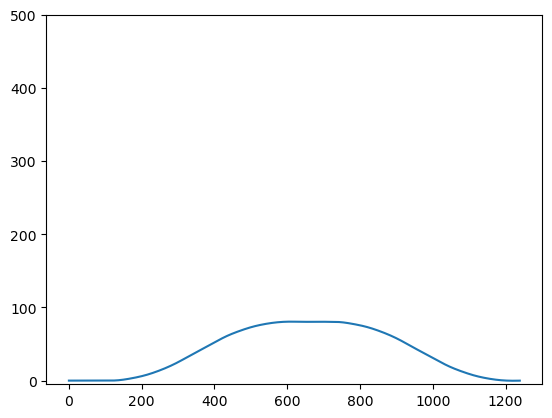

In [8]:
aa = main()

In [9]:
aa

[array([9.71596755, 0.        ]),
 array([9.52075339e+00, 2.22170583e-03]),
 array([ 9.61689335e+00, -4.20816085e-04]),
 array([9.61948003e+00, 6.62769818e-04]),
 array([ 9.65676375e+00, -5.50598480e-03]),
 array([9.40497968e+00, 3.37831594e-03]),
 array([9.67086051e+00, 1.06779975e-03]),
 array([9.56400852e+00, 1.95972484e-03]),
 array([ 9.41592752e+00, -2.80009944e-03]),
 array([ 9.49816539e+00, -2.33672462e-04]),
 array([ 9.32794081e+00, -1.02868246e-03]),
 array([9.61925543e+00, 2.12430714e-03]),
 array([ 9.37915382e+00, -4.28833540e-04]),
 array([ 9.24047063e+00, -3.71024742e-03]),
 array([9.24826467e+00, 1.56062449e-03]),
 array([9.27370007e+00, 3.64739859e-03]),
 array([ 9.10721963e+00, -3.86327944e-03]),
 array([9.12113252e+00, 1.54008532e-03]),
 array([9.1142896e+00, 2.0080866e-03]),
 array([ 9.04119141e+00, -1.24157759e-03]),
 array([ 9.08258830e+00, -2.28911436e-04]),
 array([8.85548907e+00, 1.65034692e-03]),
 array([ 8.98777424e+00, -2.10751072e-03]),
 array([8.90886892e+00

TypeError: unsupported operand type(s) for +: 'bool' and 'str'

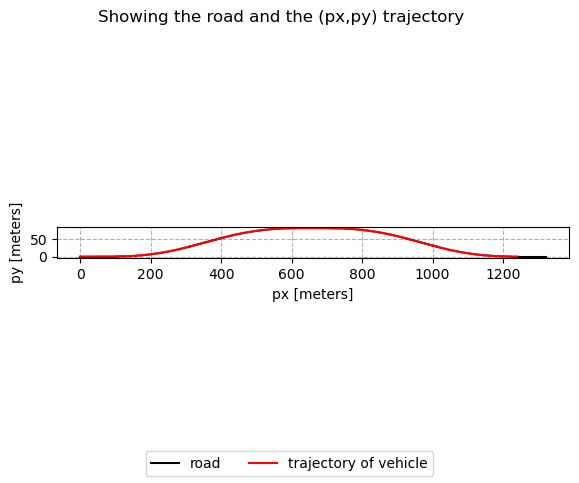

In [ ]:
# Import the function for simulating the autonomous driving environment
from evaluation_mpc.evaluation_for_autonomous_driving_mpc import simulate_policy
from evaluation_mpc.evaluation_for_autonomous_driving_mpc import plot_results_from_time_series_dict
test_env = create_env(road_elements_list = road_elements_list)
sim_time_series_dict = simulate_policy(test_env, len(aa), aa, seed=None, should_save_look_ahead_results=False, should_save_observations=False, verbose=0)
plot_details_list = plot_results_from_time_series_dict(test_env,sim_time_series_dict, False, False, False )

TypeError: unsupported operand type(s) for +: 'bool' and 'str'

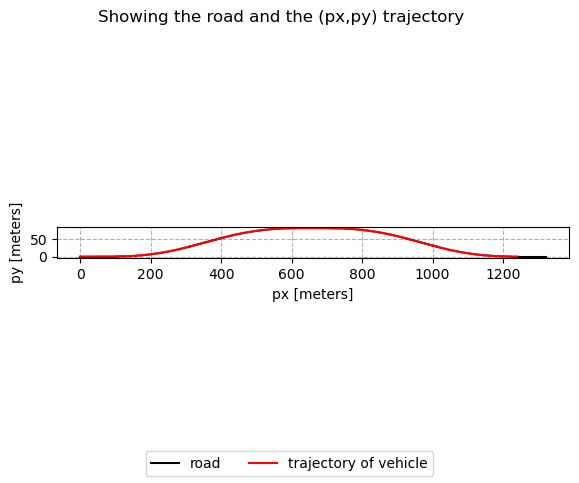